# Variables vs Tournament Outcomes V2
Looks at how previous variables compare with tournament outcomes

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os, sys
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.cluster import AffinityPropagation

#Import other files
raw_path = os.path.join('..', 'data', 'raw')
proc_path = os.path.join('..', 'data', 'processed')
sys.path.append(os.path.join('..', 'src'))
from viz.Correl import *
%matplotlib inline  

In [2]:
#Read in data
ss_v1 = pd.read_csv(os.path.join(proc_path, 'scoring_set_v1.csv'))
ss_v1 = ss_v1[ss_v1['Season']> 2003].sort_index(axis=1)

# Reads in data
seeds = pd.read_csv(os.path.join(raw_path, 'TourneySeeds.csv'))
slots = pd.read_csv(os.path.join(raw_path, 'TourneySlots.csv'))
tourney = pd.read_csv(os.path.join(raw_path, 'TourneyCompactResults.csv'))
features = pd.read_csv(os.path.join(proc_path, 'team_features.csv'))

slots = slots[slots['Season']>2003]
tourney = tourney[tourney['Season']>2003]

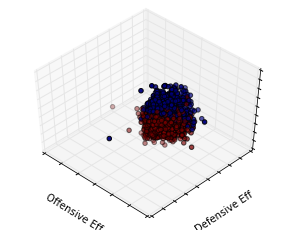

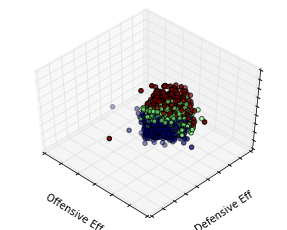

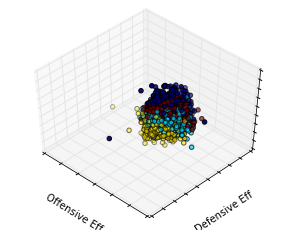

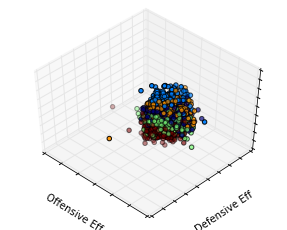

In [3]:
#Looks at clusters of ranging sizes

#finish this up, making color do nothing
X = features[['oeff', 'deff', 'total_poss']]

estimators = {'k_means_2': KMeans(n_clusters=2, random_state = 0),
              'k_means_3': KMeans(n_clusters=3, random_state = 0),
              'k_means_4': KMeans(n_clusters=4, random_state = 0),
              'k_means_5': KMeans(n_clusters=5, random_state = 0)}

fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    est.fit(X)
    labels = est.labels_

    ax.scatter(X.ix[:, 0], X.ix[:, 1], X.ix[:, 2], c=labels.astype(np.float))

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Offensive Eff')
    ax.set_ylabel('Defensive Eff')
    ax.set_zlabel('Possessions')
    fignum = fignum + 1


In [4]:
#So arbitrarily, I'm going to use k-means clusters with 3 variables with 4 groups

X = features[['oeff', 'deff', 'total_poss']]
cluster_model = KMeans(n_clusters=4, random_state = 0).fit(X)

clusters = pd.get_dummies(cluster_model.labels_)

for col in clusters.columns.values:
    col_name = 'clstr_' + str(col)
    features[col_name] = clusters[col]
    
#exports features
features.to_csv(os.path.join(proc_path, 'team_features_v2.csv'), index=False)

In [5]:
#Randomly swithces W and L teams
random_picks_to_switch = random.sample(tourney.index, len(tourney.index)/2)
replace_wl = tourney.ix[random_picks_to_switch,:].copy()
replace_wl_renamed = pd.DataFrame()
replace_wl_renamed['Wscore'] = replace_wl['Lscore']
replace_wl_renamed['Lscore'] = replace_wl['Wscore']
replace_wl_renamed['Wteam'] = replace_wl['Lteam']
replace_wl_renamed['Lteam'] = replace_wl['Wteam']
replace_wl_renamed['Season'] = replace_wl['Season']
# replace_w1 = replace_wl.rename(index=str, columns={'Wscore':'score', 'Wteam_Name':'team_Name'})
# replace_w1 = replace_wl.rename(index=str, columns={'Lscore':'Wscore', 'Lteam_Name':'Wteam_Name'})
# replace_w1 = replace_wl.rename(index=str, columns={'score':'Lscore', 'team_Name':'Lteam_Name'})
print len(tourney)
tourney = tourney.drop(random_picks_to_switch)
print len(tourney)
tourney = tourney.append(replace_wl_renamed)
print len(tourney)
tourney = tourney[['Lscore', 'Wscore', 'Wteam', 'Lteam', 'Season']].reset_index(drop=True)

850
425
850


In [6]:
#Joins features with tourney results
print len(tourney)
tourney = tourney.merge(features, left_on=['Season', 'Wteam'], right_on=['Season', 'Team'])
print len(tourney)
tourney = tourney.merge(features, left_on=['Season', 'Lteam'], right_on=['Season', 'Team'], suffixes=('_W', '_L'))
tourney = tourney.drop(['Team_W', 'Team_L'], 1)
print len(tourney)

850
850
850


In [7]:
#Creates target variable for games
tourney['Outcome'] = tourney['Wscore'] - tourney['Lscore']

In [8]:
# #Adds interaction effect for clusters
# for cw in range(4):
#     for cl in range(4):
#         clstr_w = 'clstr_' + str(cw) + '_W' 
#         clstr_l = 'clstr_' + str(cl) + '_L'
#         combo_col = clstr_w + clstr_l
#         tourney[combo_col] = tourney[clstr_w]*tourney[clstr_l]

In [9]:
#Outputs outcome data
tourney.to_csv(os.path.join(proc_path, 'scoring_set_v2.csv'), index=False)

         total_poss_W  total_poss_L    oeff_W    oeff_L    deff_W    deff_L
Outcome       0.09841     -0.118393  0.101739 -0.096896 -0.082796  0.126044


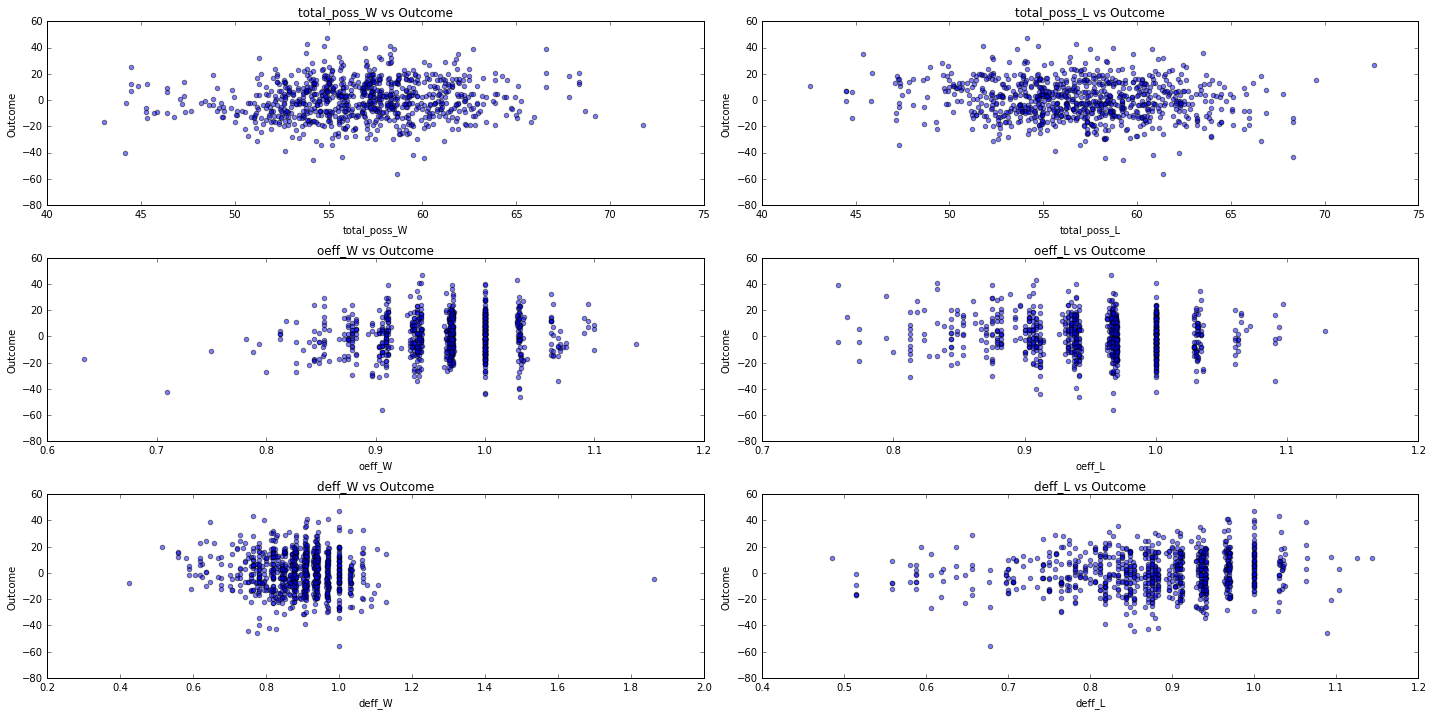

In [10]:
#Creates correlation charts for each variable
create_correl_charts(tourney, 'Outcome', ['total_poss_W', 'total_poss_L', 'oeff_W', 'oeff_L', 'deff_W', 'deff_L'])

            SOS_W     SOS_L  home_adv_W  home_adv_L
Outcome  0.333468 -0.410069    -0.10706    0.089873


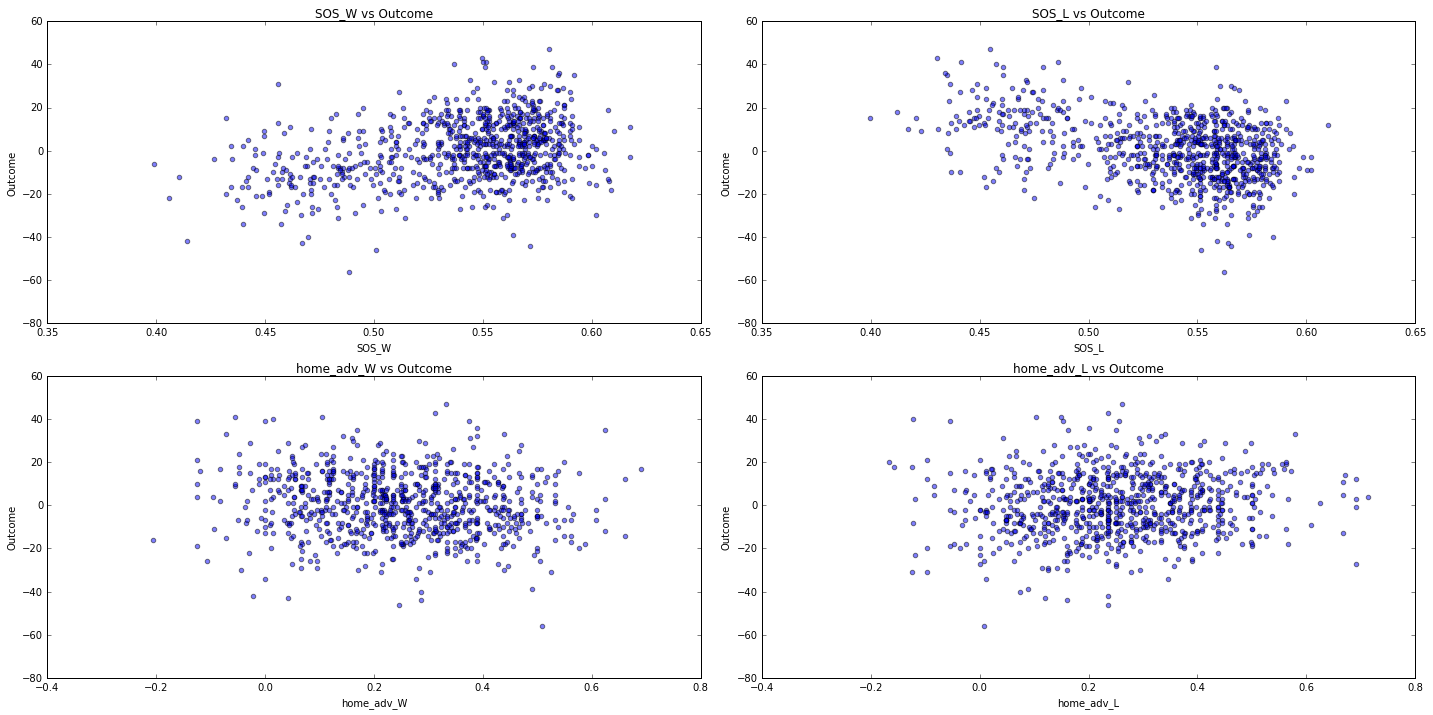

In [11]:
#Creates correlation charts for each variable
create_correl_charts(tourney, 'Outcome', ['SOS_W', 'SOS_L', 'home_adv_W', 'home_adv_L'])

            o3P_W     o3P_L     d3P_W     d3P_L
Outcome -0.027783 -0.016584 -0.019663 -0.076281


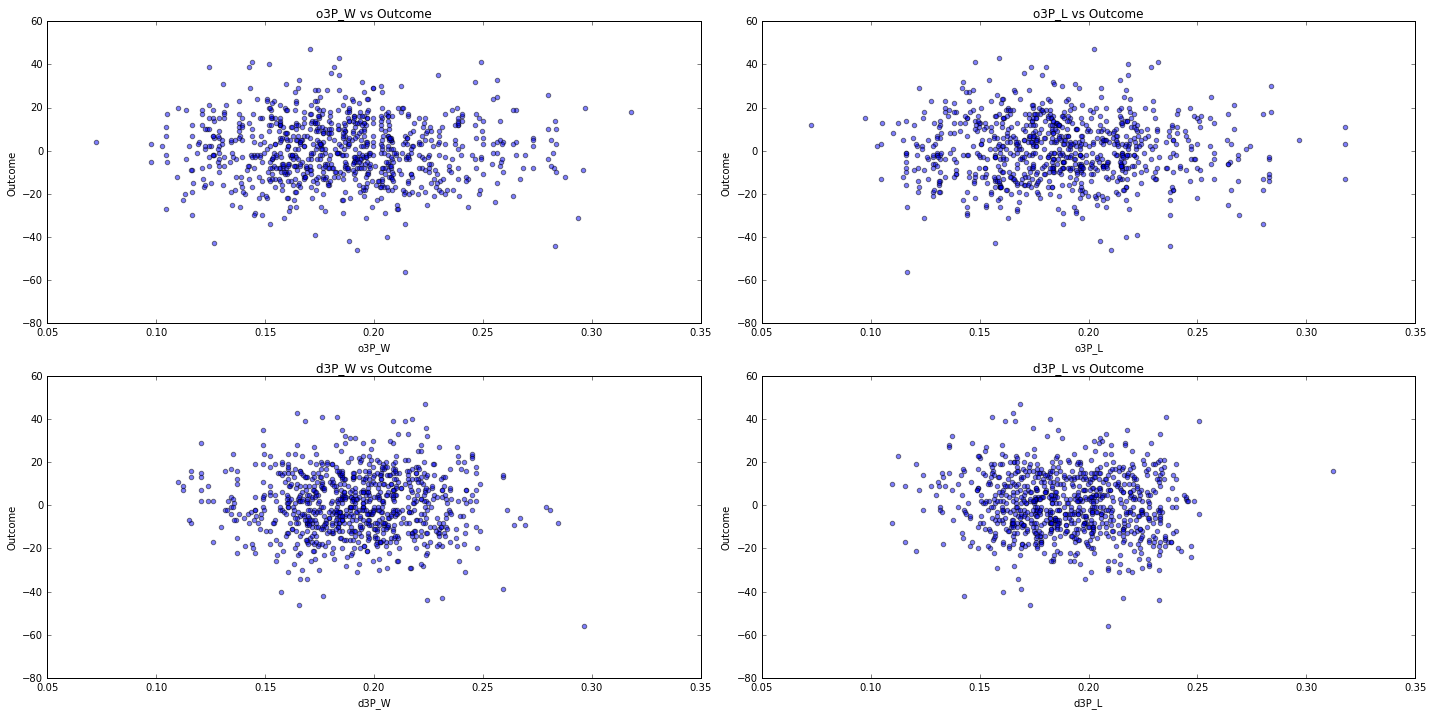

In [12]:
#Creates correlation charts for each variable
create_correl_charts(tourney, 'Outcome', ['o3P_W', 'o3P_L', 'd3P_W', 'd3P_L'])

         WinPct_W  WinPct_L  Clutch_W  Clutch_L
Outcome  0.351191 -0.306408 -0.106519  0.151802


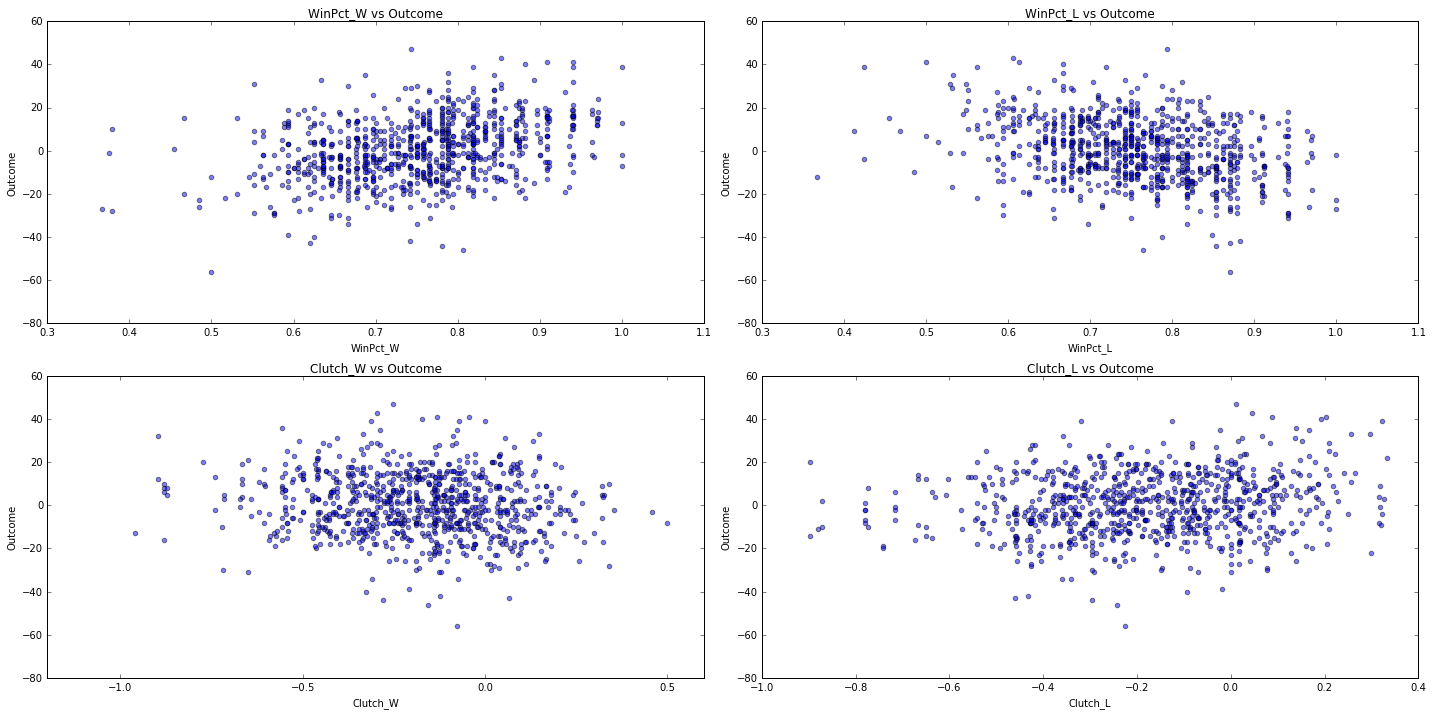

In [13]:
#Creates correlation charts for each variable
create_correl_charts(tourney, 'Outcome', ['WinPct_W', 'WinPct_L', 'Clutch_W', 'Clutch_L'])

         clstr_0_W  clstr_0_L  clstr_1_W  clstr_1_L
Outcome   0.038103  -0.068161  -0.093241   0.089495


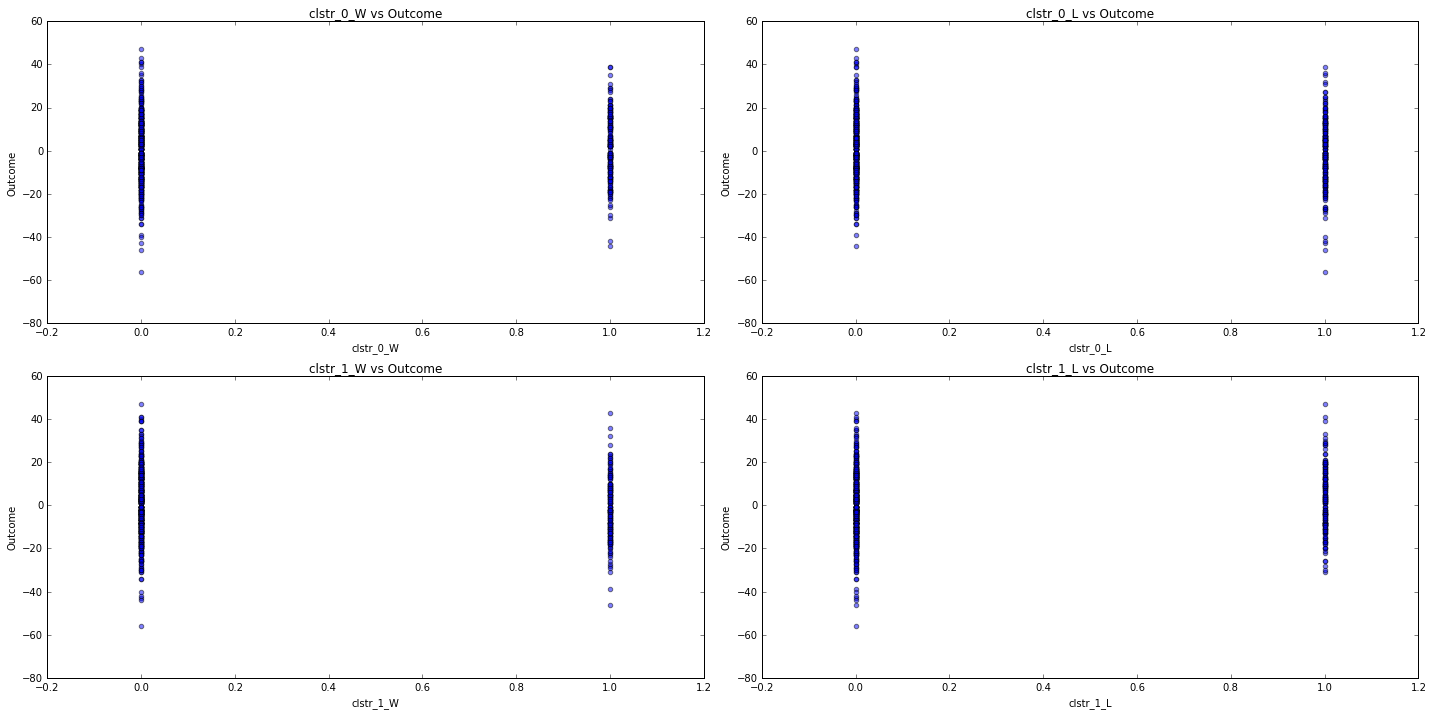

In [14]:
#Creates correlation charts for each variable
create_correl_charts(tourney, 'Outcome', ['clstr_0_W', 'clstr_0_L', 'clstr_1_W', 'clstr_1_L'])

         clstr_2_W  clstr_2_L  clstr_3_W  clstr_3_L
Outcome  -0.041203   0.047633   0.060858  -0.030136


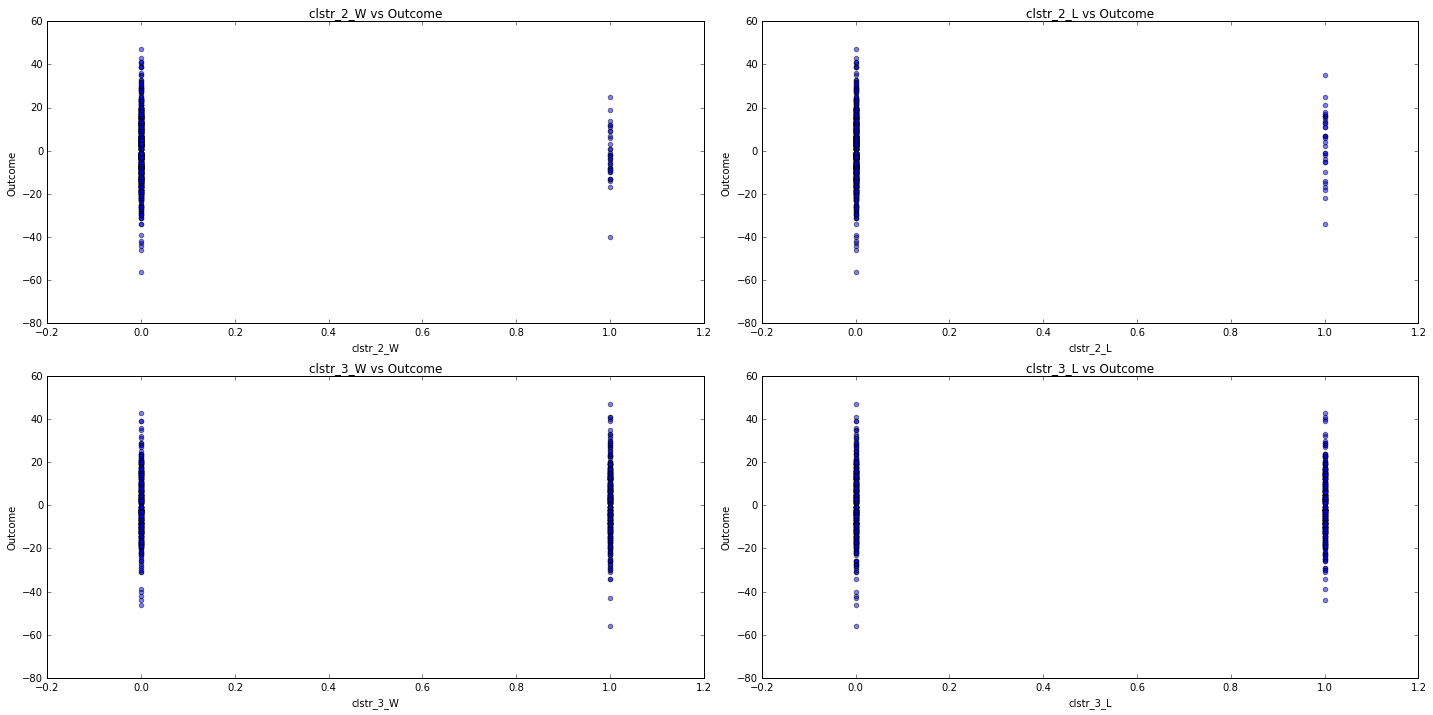

In [15]:
#Creates correlation charts for each variable
create_correl_charts(tourney, 'Outcome', ['clstr_2_W', 'clstr_2_L', 'clstr_3_W', 'clstr_3_L'])

In [16]:
# #Creates k-means clusters with 2, 3, 4, and 5 groups
# x_cluster = ss_v1[['total_poss_W', 'oeff_W', 'deff_W']]
# colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'r', 'm']
# fig = plt.figure()

# for n_clusters in [2,3,4,5]:
#     kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(x_cluster)
#     k_means_cluster_centers = np.sort(kmeans.cluster_centers_, axis=0)
#     k_means_labels = pairwise_distances_argmin(x_cluster, k_means_cluster_centers)

#     ax = fig.add_subplot(2, 2, n_clusters-1)
#     for k, col in zip(range(n_clusters), colors):
#         my_members = k_means_labels == k
#         cluster_center = k_means_cluster_centers[k]
#         ax.plot(x_cluster.ix[my_members, 0], x_cluster.ix[my_members, 1], 'w',
#                 markerfacecolor=col, marker='.')
#         ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#                 markeredgecolor='k', markersize=6)
#     ax.set_title('KMeans: ' + str(n_clusters))
#     #ax.set_xticks(())
#     #ax.set_yticks(())
    
# fig.tight_layout()